<a href="https://colab.research.google.com/github/Vargol/StableDiffusionColabs/blob/main/faceid_sdxl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy insightface einops onnxruntime
! git clone https://github.com/tencent-ailab/IP-Adapter.git
! curl -Lo ip-adapter-faceid_sdxl.bin https://huggingface.co/h94/IP-Adapter-FaceID/resolve/main/ip-adapter-faceid-plusv2_sdxl.bin?download=true

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 23.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.9 MB/s eta 0:00:00
Cloning into 'IP-A

In [ ]:
import mediapy as media
import random
import sys
import torch
import gc
import time
import cv2

from insightface.app import FaceAnalysis
from insightface.utils import face_align

from diffusers import DiffusionPipeline, AutoencoderKL, UniPCMultistepScheduler

sys.path.insert(0,'/content/IP-Adapter')

from ip_adapter.ip_adapter_faceid import IPAdapterFaceIDPlusXL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
                                    torch_dtype=torch.float16,
                                    force_upcast=False).to('cuda')


styles = {
"Enhance" : {
"Positive" : "breathtaking {prompt} . award-winning, professional, highly detailed",
"Negative" : "ugly, deformed, noisy, blurry, distorted, grainy",
},
"Anime" : {
"Positive" : "anime artwork {prompt} . anime style, key visual, vibrant, studio anime,  highly detailed",
"Negative" : "photo, deformed, black and white, realism, disfigured, low contrast",
},
"Photographic" : {
"Positive" : "cinematic photo {prompt} . 35mm photograph, film, bokeh, professional, 4k, highly detailed",
"Negative" : "drawing, painting, crayon, sketch, graphite, impressionist, noisy, blurry, soft, deformed, ugly",
},
"Digital art" : {
"Positive" : "concept art {prompt} . digital artwork, illustrative, painterly, matte painting, highly detailed",
"Negative" : "photo, photorealistic, realism, ugly",
},
"Comic book" : {
"Positive" : "comic {prompt} . graphic illustration, comic art, graphic novel art, vibrant, highly detailed",
"Negative" : "photograph, deformed, glitch, noisy, realistic, stock photo",
},
"Fantasy art" : {
"Positive" : "ethereal fantasy concept art of  {prompt} . magnificent, celestial, ethereal, painterly, epic, majestic, magical, fantasy art, cover art, dreamy",
"Negative" : "photographic, realistic, realism, 35mm film, dslr, cropped, frame, text, deformed, glitch, noise, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, sloppy, duplicate, mutated, black and white",
},
"Analog film" : {
"Positive" : "analog film photo {prompt} . faded film, desaturated, 35mm photo, grainy, vignette, vintage, Kodachrome, Lomography, stained, highly detailed, found footage",
"Negative" : "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
},
"Neonpunk" : {
"Positive" : "neonpunk style {prompt} . cyberpunk, vaporwave, neon, vibes, vibrant, stunningly beautiful, crisp, detailed, sleek, ultramodern, magenta highlights, dark purple shadows, high contrast, cinematic, ultra detailed, intricate, professional",
"Negative" : "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
},
"Isometric" : {
"Positive" : "isometric style {prompt} . vibrant, beautiful, crisp, detailed, ultra detailed, intricate",
"Negative" : "deformed, mutated, ugly, disfigured, blur, blurry, noise, noisy, realistic, photographic",
},
"Lowpoly" : {
"Positive" : "low-poly style {prompt} . low-poly game art, polygon mesh, jagged, blocky, wireframe edges, centered composition",
"Negative" : "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Origami" : {
"Positive" : "origami style {prompt} . paper art, pleated paper, folded, origami art, pleats, cut and fold, centered composition",
"Negative" : "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Line art" : {
"Positive" : "line art drawing {prompt} . professional, sleek, modern, minimalist, graphic, line art, vector graphics",
"Negative" : "anime, photorealistic, 35mm film, deformed, glitch, blurry, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, mutated, realism, realistic, impressionism, expressionism, oil, acrylic",
},
"Craft clay" : {
"Positive" : "play-doh style {prompt} . sculpture, clay art, centered composition, Claymation",
"Negative" : "sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Cinematic" : {
"Positive" : "cinematic film still {prompt} . shallow depth of field, vignette, highly detailed, high budget Hollywood movie, bokeh, cinemascope, moody, epic, gorgeous, film grain, grainy",
"Negative" : "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured",
},
"3d-model" : {
"Positive" : "professional 3d model {prompt} . octane render, highly detailed, volumetric, dramatic lighting",
"Negative" : "ugly, deformed, noisy, low poly, blurry, painting",
},
"Pixel art" : {
"Positive" : "pixel-art {prompt} . low-res, blocky, pixel art style, 8-bit graphics",
"Negative" : "sloppy, messy, blurry, noisy, highly detailed, ultra textured, photo, realistic",
},
"Texture" : {
"Positive" : "texture {prompt} top down close-up",
"Negative" : "ugly, deformed, noisy, blurry",
}
}

aspects = {
"12:5" :  { 'x' : 1536  , 'y' :  640 },
"7:4" :   { 'x' : 1344  , 'y' :  768 },
"19:13" : { 'x' : 1216  , 'y' :  832  },
"9:7" :   { 'x' : 1152 , 'y' : 896  },
"1:1" :   { 'x' : 1024 , 'y' : 1024 },
"7:9" :   { 'x' : 896  , 'y' : 1152  },
"13:19" : { 'x' : 832  , 'y' :  1216 },
"4:7" :   { 'x' : 768  , 'y' :  1344 },
"5:12" :  { 'x' : 640  , 'y' :  1536 }
}




The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
model_id = "ptx0/terminus-xl-gamma-v2"
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
model_id = "dataautogpt3/OpenDalleV1.1"
model_id = "SG161222/RealVisXL_V3.0"
#model_id ="stablediffusionapi/zavychromaxl"

ip_ckpt = "ip-adapter-faceid_sdxl.bin"
image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"



app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

pipe = DiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    vae=vae
    ).to('cuda')

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_vae_tiling()
ip_model = IPAdapterFaceIDPlusXL(pipe, image_encoder_path, ip_ckpt, 'cuda')






download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:05<00:00, 47993.85KB/s]
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

The next cell is where you set you parameters and run Stable Diffusion.

The cell is re-runable, so you can edit the parameters and run without recreating the environment


  0%|          | 0/45 [00:00<?, ?it/s]

Prompt:	commander shepard, femshep, In the Movie of Mass Effect designed by Moebius
Style:	Cinematic
Seed:	8101963469565879079



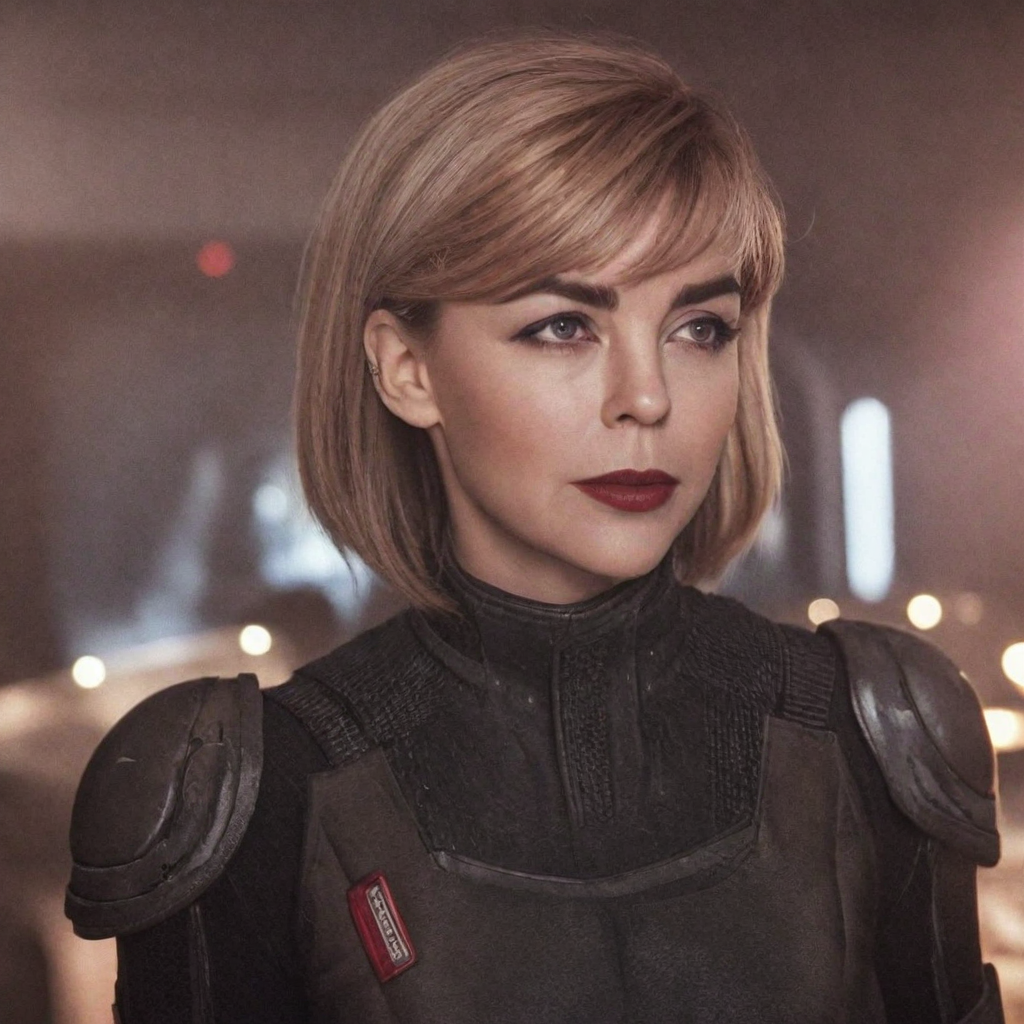

  0%|          | 0/45 [00:00<?, ?it/s]

Prompt:	commander shepard, femshep, In the Movie of Mass Effect designed by Moebius
Style:	Cinematic
Seed:	4278312256282518859



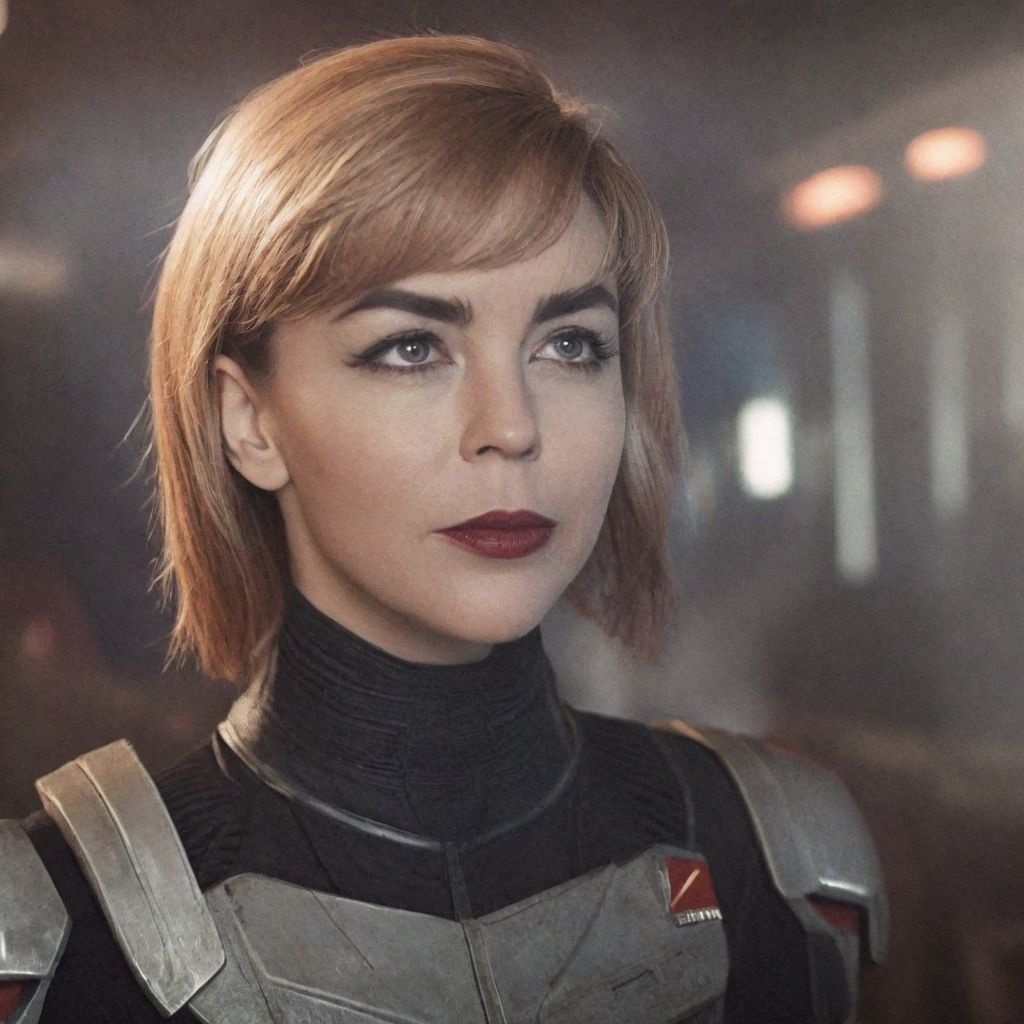

  0%|          | 0/45 [00:00<?, ?it/s]

Prompt:	commander shepard, femshep, In the Movie of Mass Effect designed by Moebius
Style:	Cinematic
Seed:	2472422430574629436



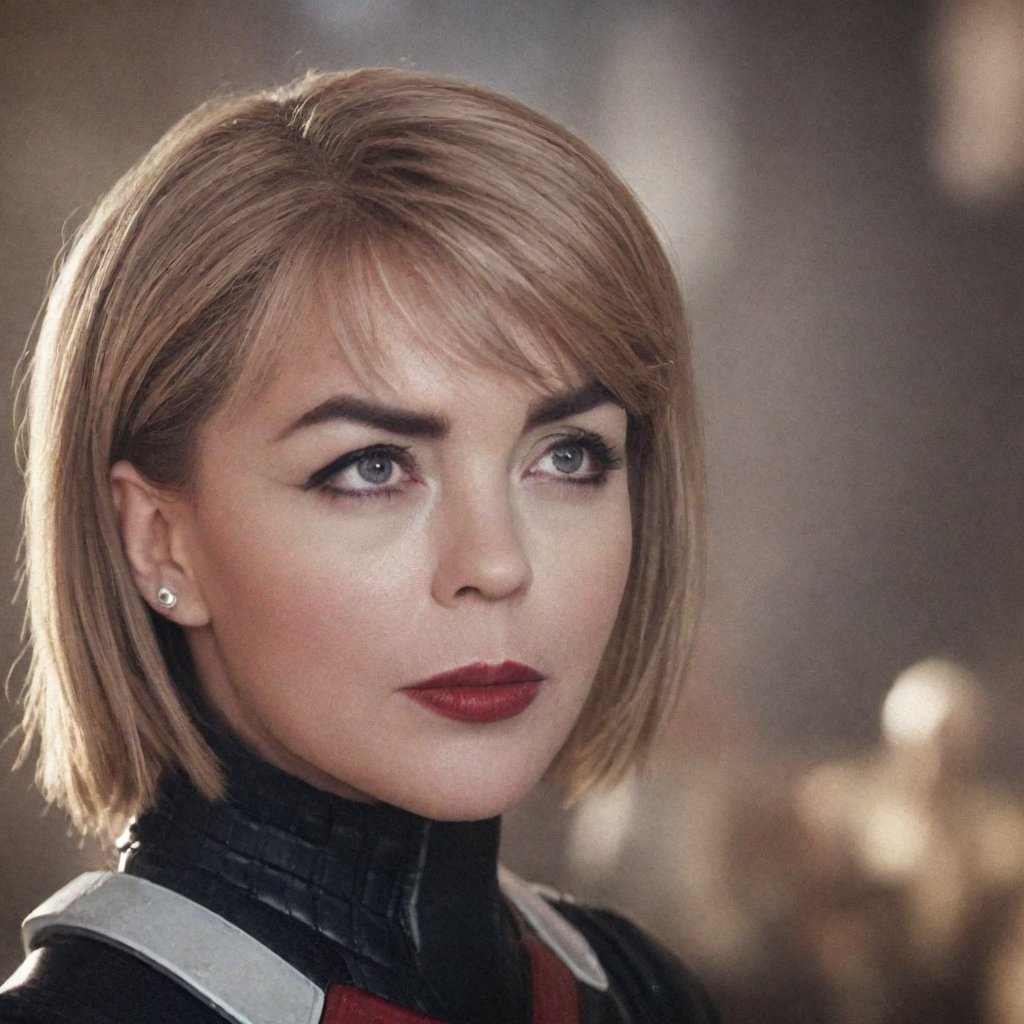

  0%|          | 0/45 [00:00<?, ?it/s]

Prompt:	commander shepard, femshep, In the Movie of Mass Effect designed by Moebius
Style:	Cinematic
Seed:	8033225575249322001



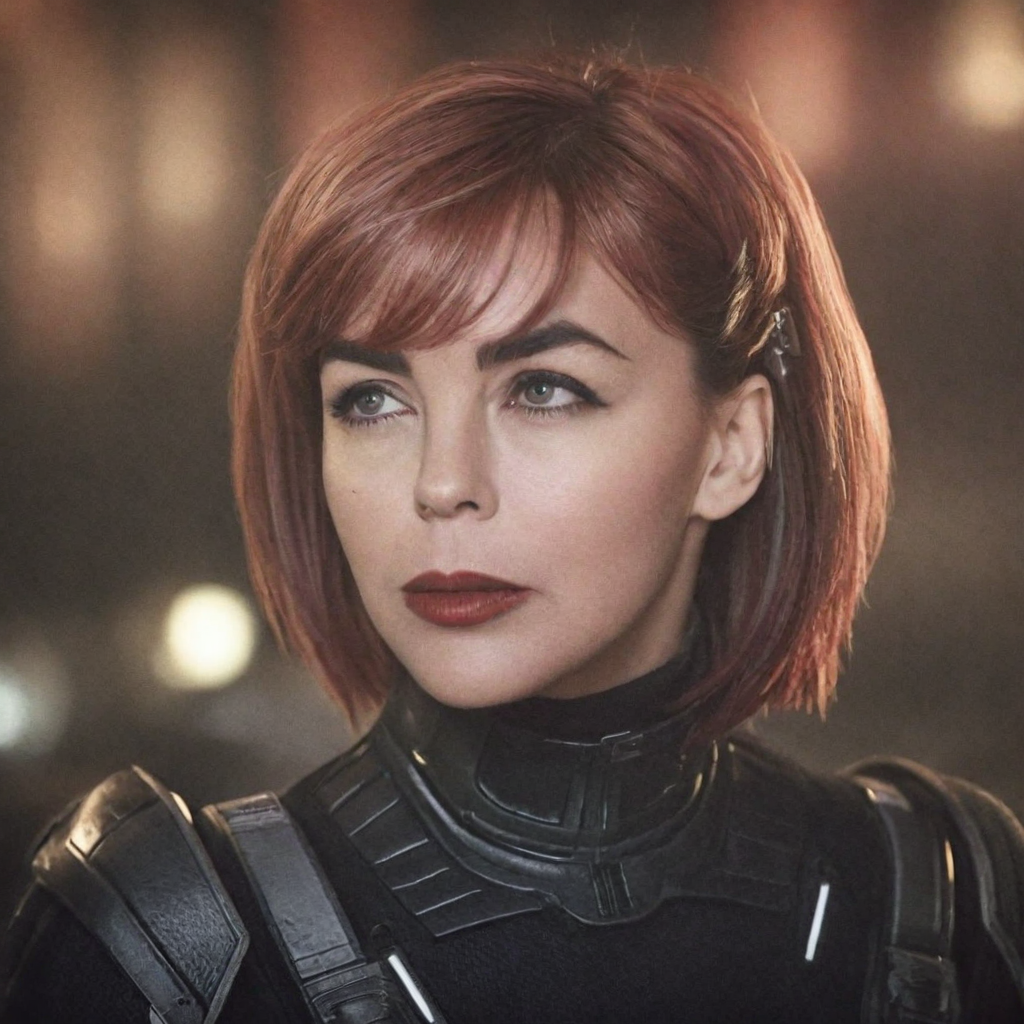

In [ ]:
prompt = 'Nina Hagen as Sappho by Auguste Mengin'
prompt = 'A red haired woman standing in a lush green jungle'
prompt = 'A woman standing in a lush green jungle'
prompt = 'commander shepard, femshep, In the Movie of Mass Effect designed by Moebius'

image_count = 4
num_inference_steps=45
style = "Cinematic"
aspect = "1:1"



image = cv2.imread("/content/d.jpg")
faces = app.get(image)

faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)
face_image = face_align.norm_crop(image, landmark=faces[0].kps, image_size=224) # you can also segment the face
media.show_images(face_image)

orig_prompt = prompt
prompt = styles[style]["Positive"].replace("{prompt}", prompt)
negative_prompt = styles[style]["Negative"]

torch.cuda.empty_cache()


for i in range(image_count):

  seed = random.randint(0, sys.maxsize)

  images = ip_model.generate(
    prompt=prompt, negative_prompt=negative_prompt,
    face_image=face_image,faceid_embeds=faceid_embeds,
    shortcut=True, s_scale=1.3, scale=1.0,
    num_samples=1,
    width=1024, height=1024,
    num_inference_steps=num_inference_steps, guidance_scale=1.5, seed=seed
    )

  print(f"Prompt:\t{orig_prompt}\nStyle:\t{style}\nSeed:\t{seed}")
  media.show_images(images)
